In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import scipy.stats as stats

%matplotlib inline

### Open pickles for all three data sets

In [56]:
with open('rookies_totals.pickle', 'rb') as to_read:
    totals = pickle.load(to_read)

with open('rookies_games.pickle', 'rb') as to_read:
    games = pickle.load(to_read)
    
with open('rookies_minutes.pickle', 'rb') as to_read:
    minutes = pickle.load(to_read)

In [57]:
# Remove an erroneous value
totals.drop(100, axis=0, inplace=True)
totals.reset_index().drop(['index'], axis=1, inplace=True)

### Setup structure for numerical data frame columns

In [58]:
# Different column names for different modelling patterns
basic = ['SALARY','G','GS','MP','FG','FGA','FG_PCT','FG3','FG3A','FG3_PCT','FG2','FG2A','FG2_PCT','EFG_PCT','FT',
         'FTA','FT_PCT','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']

advanced = ['DWS','WS', 'OWS', 'PER', 'BLK_PCT', 'VORP', 'TRB_PCT', 'FG3A_PER_FGA_PCT','OBPM', 'WS_PER_48', 'BPM',
            'DRB_PCT', 'STL_PCT', 'TOV_PCT', 'TS_PCT','USG_PCT', 'DBPM', 'FTA_PER_FGA_PCT', 'AST_PCT', 'ORB_PCT']

basic_min = ['SALARY','G','GS','MP','FG','FGA','FG_PCT','FG3','FG3A','FG3_PCT','FG2','FG2A','FG2_PCT','FT','FTA',
             'FT_PCT','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']

### Create linear regression model

In [92]:
def run_linear_regression(df):
    lm = LinearRegression()
    
    y = df.iloc[:,0]
    X = df.iloc[:,1:]
    
    # Split data into train set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create cross validation fold
    kf = KFold(n_splits=5, shuffle=True, random_state=43)
    
    # Fit linear regression model on training data
    lm.fit(X_train, y_train)
    
    # Get CV R^2 and test R^2
    print('CV Score', np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')))
    print('R^2', lm.score(X_test, y_test))
    
    # Make a prediction and get residuals
    pred = lm.predict(X_test)
    res = y_test - pred
    
    plt.figure(figsize=[10,5])
    
    # Plot residuals
    plt.subplot(1, 2, 1)
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    # Make QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

### Run different linear regressions

CV Score -0.04205138533015784
R^2 -0.007406446345588735


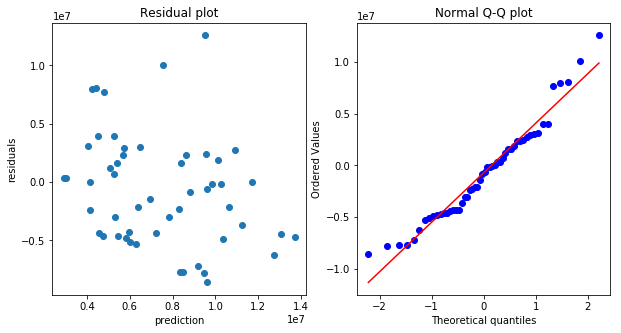

In [93]:
# Basic linear regression for totals data
totals_num = totals[basic]
run_linear_regression(totals_num)

CV Score -0.04090976861487883
R^2 -0.022534800342336236


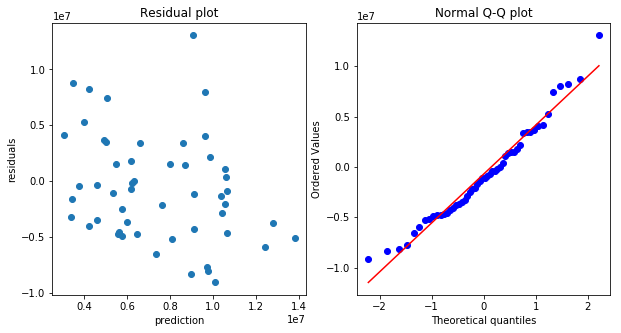

In [94]:
# Basic linear regression for by games data
games_num = games[basic]
run_linear_regression(games_num)

CV Score 0.02627968371770837
R^2 -0.0552557962592608


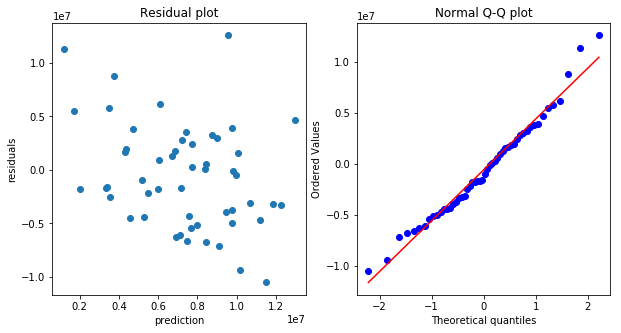

In [95]:
# Basic linear regression for by minutes data
minutes_num = minutes[basic_min]
run_linear_regression(minutes_num)

CV Score 0.012488205787409279
R^2 0.04124858600576231


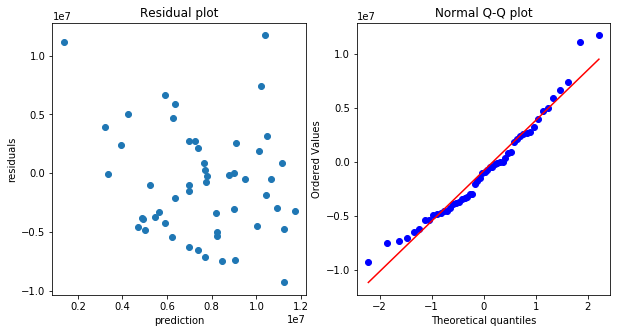

In [96]:
# Linear regression for just advanced statistics
advanced_num = totals[advanced]
advanced_num.insert(0, 'SALARY', pd.Series(totals['SALARY']))
run_linear_regression(advanced_num)

CV Score -0.06419357253521214
R^2 -0.2679962852580535


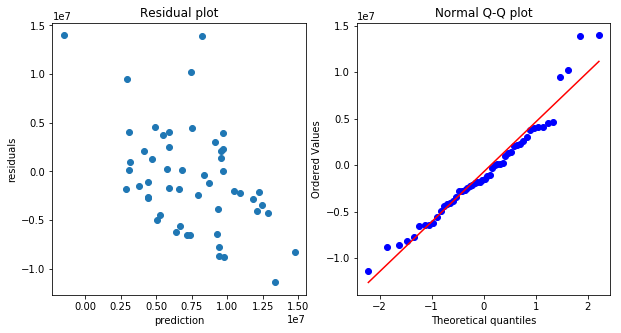

In [97]:
# Linear regression of advanced statistics with basic total statistics
totals_num = totals[basic + advanced]
run_linear_regression(totals_num)

CV Score -0.22615400171339878
R^2 -0.24505925817183938


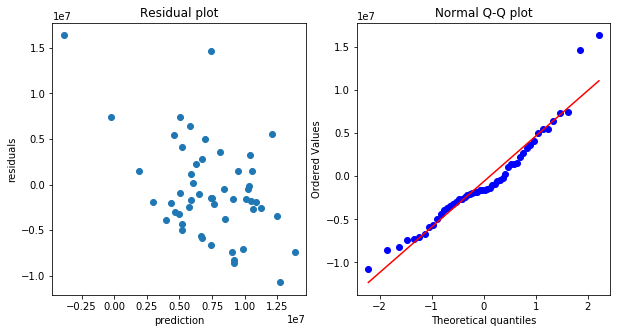

In [98]:
# Linear regression of basic per game statistics added to advanced statistics
games_num = games[basic + advanced]
run_linear_regression(games_num)

CV Score -0.13037132584200728
R^2 0.045660801330679957


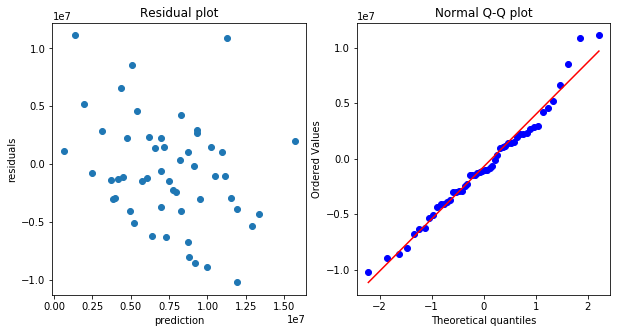

In [99]:
# Linear regression of per 36 minutes basic statistics with advanced statistics
minutes_num = minutes[basic_min + advanced]
run_linear_regression(minutes_num)

### Create lasso cross-validation model

In [77]:
def run_lasso_cross(df, alphas):

    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    kf = KFold(n_splits = 5, shuffle=True, random_state=43)
    
    lcv = LassoCV(alphas = alphas, cv=kf)
    lcv.fit(X_train, y_train)

    print(lcv.alpha_)
    print(lcv.score(X_test, y_test))
    return list(zip(X.columns, lcv.coef_))

### Run cross-validation lasso against all three data sets

In [87]:
# Alpha range to try
alphas = np.arange(100000, 1000000, 100)

# Lasso regression against total statistics
totals_coefs = run_lasso_cross(totals_num, alphas)
totals_coefs

499500
0.1429027424155248


[('G', 0.0),
 ('GS', 319982.98352747597),
 ('MP', 0.0),
 ('FG', 0.0),
 ('FGA', 0.0),
 ('FG_PCT', -0.0),
 ('FG3', 0.0),
 ('FG3A', 0.0),
 ('FG3_PCT', 256935.6769014001),
 ('FG2', 0.0),
 ('FG2A', 0.0),
 ('FG2_PCT', 0.0),
 ('EFG_PCT', 0.0),
 ('FT', 0.0),
 ('FTA', 558317.6470454944),
 ('FT_PCT', -0.0),
 ('ORB', 0.0),
 ('DRB', 0.0),
 ('TRB', 0.0),
 ('AST', 0.0),
 ('STL', 0.0),
 ('BLK', 438955.378959165),
 ('TOV', 610771.8263599997),
 ('PF', 0.0),
 ('PTS', 0.0),
 ('DWS', 0.0),
 ('WS', 0.0),
 ('OWS', 0.0),
 ('PER', 0.0),
 ('BLK_PCT', -0.0),
 ('VORP', 579424.9648303128),
 ('TRB_PCT', 0.0),
 ('FG3A_PER_FGA_PCT', 0.0),
 ('OBPM', 0.0),
 ('WS_PER_48', 0.0),
 ('BPM', 0.0),
 ('DRB_PCT', 0.0),
 ('STL_PCT', 0.0),
 ('TOV_PCT', 0.0),
 ('TS_PCT', -0.0),
 ('USG_PCT', 0.0),
 ('DBPM', 20773.399342370984),
 ('FTA_PER_FGA_PCT', 0.0),
 ('AST_PCT', 0.0),
 ('ORB_PCT', -0.0)]

In [88]:
# Lasso regression against per-game statistics
games_coefs = run_lasso_cross(games_num, alphas)
games_coefs

543300
0.13183057709961754


[('G', 0.0),
 ('GS', 39809.41436170135),
 ('MP', 129453.06565367103),
 ('FG', 269812.421781987),
 ('FGA', 0.0),
 ('FG_PCT', -0.0),
 ('FG3', 0.0),
 ('FG3A', 0.0),
 ('FG3_PCT', 51344.48750820502),
 ('FG2', 0.0),
 ('FG2A', 0.0),
 ('FG2_PCT', 0.0),
 ('EFG_PCT', 0.0),
 ('FT', 0.0),
 ('FTA', 314445.48354813334),
 ('FT_PCT', -0.0),
 ('ORB', 0.0),
 ('DRB', 627824.9654612676),
 ('TRB', 0.0),
 ('AST', 0.0),
 ('STL', 0.0),
 ('BLK', 0.0),
 ('TOV', 675606.8813743865),
 ('PF', 0.0),
 ('PTS', 0.0),
 ('DWS', 0.0),
 ('WS', 0.0),
 ('OWS', 0.0),
 ('PER', 0.0),
 ('BLK_PCT', 0.0),
 ('VORP', 358245.8427115077),
 ('TRB_PCT', -0.0),
 ('FG3A_PER_FGA_PCT', 0.0),
 ('OBPM', 0.0),
 ('WS_PER_48', 0.0),
 ('BPM', 0.0),
 ('DRB_PCT', 0.0),
 ('STL_PCT', 0.0),
 ('TOV_PCT', 0.0),
 ('TS_PCT', -0.0),
 ('USG_PCT', 0.0),
 ('DBPM', 73534.41862663713),
 ('FTA_PER_FGA_PCT', 0.0),
 ('AST_PCT', -0.0),
 ('ORB_PCT', -0.0)]

In [89]:
# Lasso regression against by 36-minute statistics
minutes_coefs = run_lasso_cross(minutes_num, alphas)
minutes_coefs

282200
0.18060064889015448


[('G', 0.0),
 ('GS', 833525.9230031274),
 ('MP', 581534.8665773957),
 ('FG', 44454.743183784194),
 ('FGA', 0.0),
 ('FG_PCT', -0.0),
 ('FG3', 0.0),
 ('FG3A', 0.0),
 ('FG3_PCT', 440550.46410046297),
 ('FG2', 0.0),
 ('FG2A', 0.0),
 ('FG2_PCT', -0.0),
 ('FT', 0.0),
 ('FTA', 349012.8206842066),
 ('FT_PCT', -0.0),
 ('ORB', -0.0),
 ('DRB', 250299.28948021407),
 ('TRB', 0.0),
 ('AST', -0.0),
 ('STL', 0.0),
 ('BLK', 0.0),
 ('TOV', 325257.3427723953),
 ('PF', -434833.1370182348),
 ('PTS', 0.0),
 ('DWS', 0.0),
 ('WS', 0.0),
 ('OWS', 0.0),
 ('PER', 0.0),
 ('BLK_PCT', 0.0),
 ('VORP', 504406.4858711359),
 ('TRB_PCT', 0.0),
 ('FG3A_PER_FGA_PCT', 0.0),
 ('OBPM', 0.0),
 ('WS_PER_48', -0.0),
 ('BPM', 0.0),
 ('DRB_PCT', 0.0),
 ('STL_PCT', 0.0),
 ('TOV_PCT', 0.0),
 ('TS_PCT', -0.0),
 ('USG_PCT', 0.0),
 ('DBPM', 478999.901993672),
 ('FTA_PER_FGA_PCT', 0.0),
 ('AST_PCT', -0.0),
 ('ORB_PCT', -0.0)]

### Test linear regression with new list of features

In [101]:
# New list of features to test
new_num = ['SALARY','GS','FG3_PCT','TOV','FTA','FT_PCT','STL','BLK', 'DRB', 'FG','VORP','STL_PCT','DBPM']

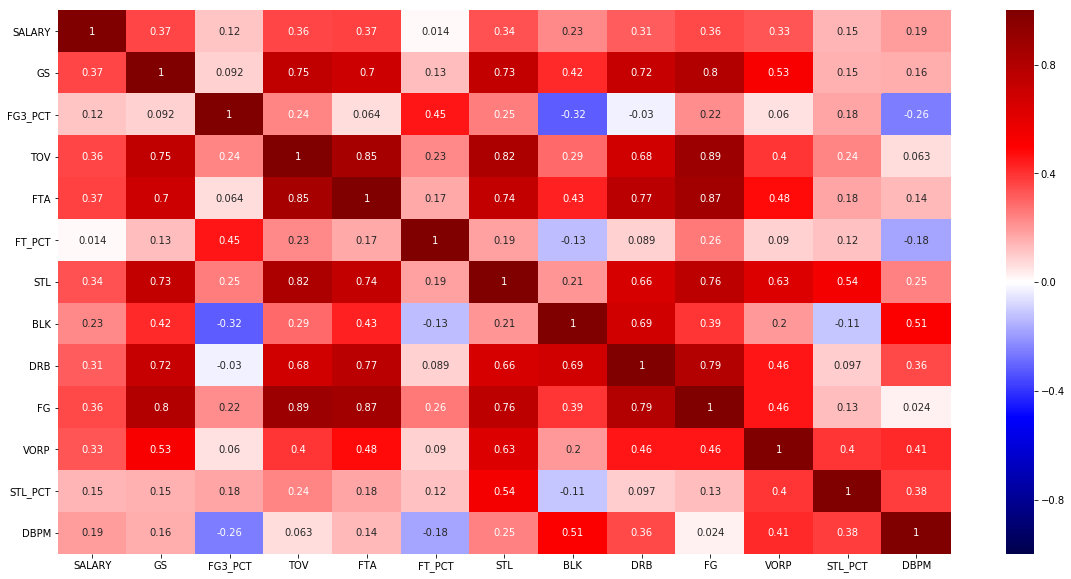

In [108]:
# Correlation heatmap for total statistics of new features
totals_num_new = totals_num[new_num]
plt.figure(figsize=[20,10])
sns.heatmap(totals_num_new.corr(), cmap='seismic', annot=True,vmin=-1, vmax=1);

CV Score 0.0433240522744035
R^2 0.12084652136518015


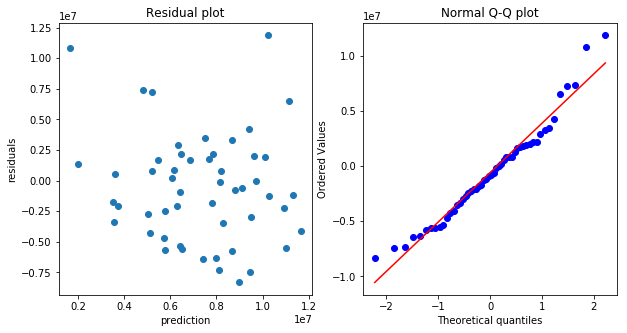

In [109]:
# Linear regression against new features for total statistics
run_linear_regression(totals_num_new)

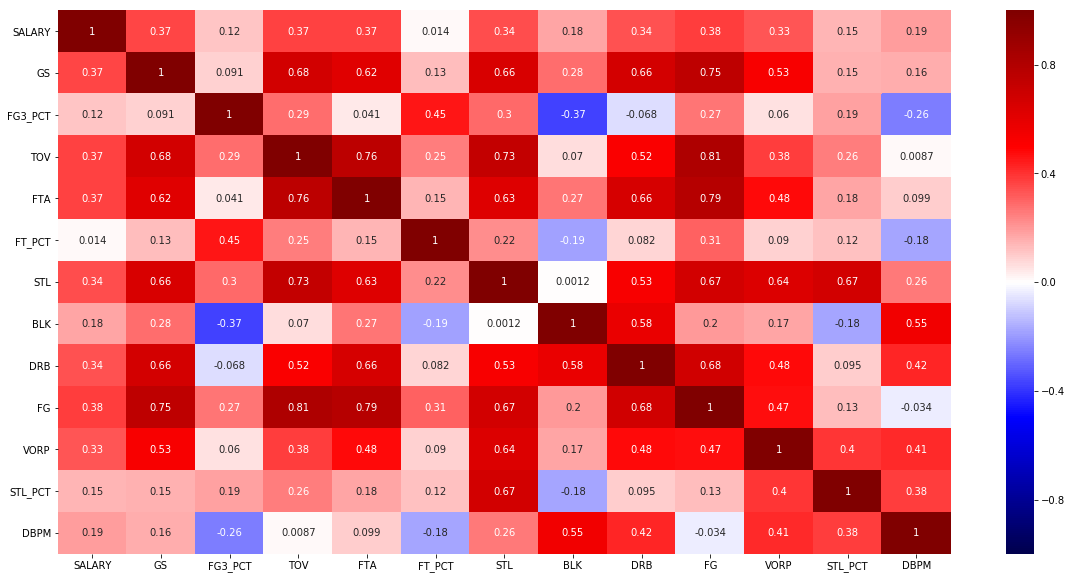

In [110]:
# Correlation heatmap for by-game statistics with new features
games_num_new = games_num[new_num]
plt.figure(figsize=[20,10])
sns.heatmap(games_num_new.corr(), cmap='seismic', annot=True,vmin=-1, vmax=1);

CV Score 0.05840728820356167
R^2 0.06316819313940647


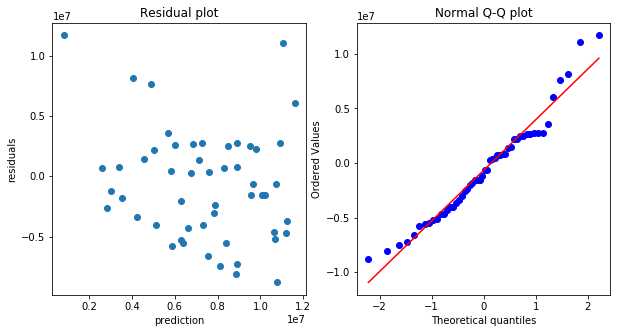

In [111]:
# Linear regression for by-game statistics
run_linear_regression(games_num_new)

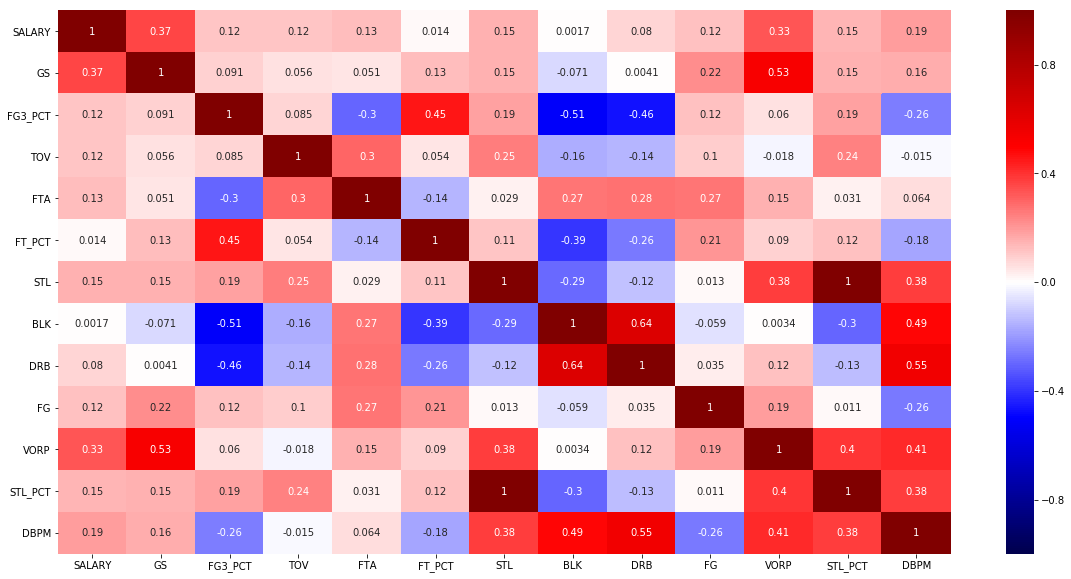

In [112]:
# Correlation heatmap for per 36-minute statistics
minutes_num_new = minutes_num[new_num]
plt.figure(figsize=[20,10])
sns.heatmap(minutes_num_new.corr(), cmap='seismic', annot=True,vmin=-1, vmax=1);

CV Score 0.04502581643716412
R^2 0.14069095972269507


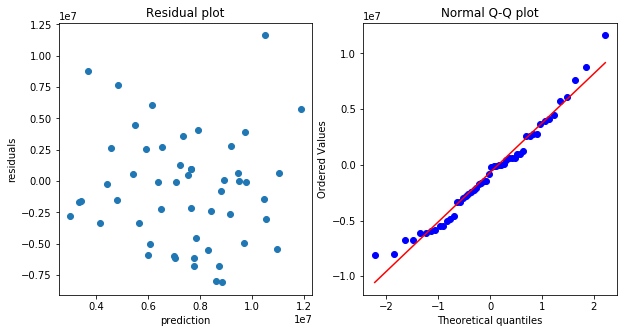

In [113]:
# Linear regression for per 36-minute statistics with new features
run_linear_regression(minutes_num_new)

### Run least angle regression against per 36-minute statistics with new features

In [114]:
X = minutes_num_new.iloc[:,1:]
y = minutes_num_new.iloc[:,0]

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

X_train_scaled = scaler.fit_transform(X_train)

# Create LARS model
alphas, _, coefs = lars_path(X_train_scaled, y_train, method='lasso')

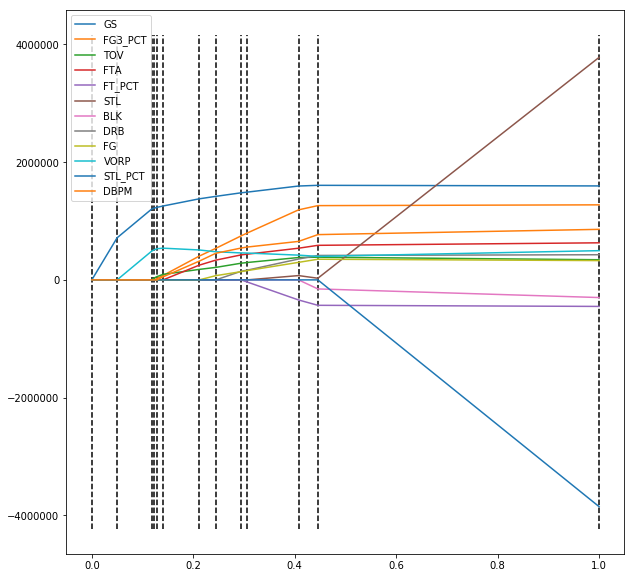

In [115]:
# Make LARS plot
xx = np.sum(np.abs(coefs.T), axis = 1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.axis('tight')

plt.legend(X_train.columns)
plt.show()

### Conclusions

After running the lasso regression against all three data sets and picking out the common features for each, running a linear regression against the new features for all three data sets clearly shows that the per 36-minute period model is the most accurate. 